In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv("../data/Food_Delivery_Times.csv")
df.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


### Data Quality and Cleanliness

In [3]:
## Missing values
df.isna().sum()

Order_ID                   0
Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64

In [4]:
## Data Type
df.dtypes

Order_ID                    int64
Distance_km               float64
Weather                    object
Traffic_Level              object
Time_of_Day                object
Vehicle_Type               object
Preparation_Time_min        int64
Courier_Experience_yrs    float64
Delivery_Time_min           int64
dtype: object

In [5]:
cat_col = df.select_dtypes(include=['object','category']).columns.tolist()
num_col = df.select_dtypes(include=['int','float']).columns.tolist()
num_col.remove('Delivery_Time_min')
num_col.remove('Order_ID')
target_variable = 'Delivery_Time_min'

In [6]:
## Consistency
for col in cat_col:
    print(f'--{col}--')
    print(df[col].unique())

--Weather--
['Windy' 'Clear' 'Foggy' 'Rainy' 'Snowy' nan]
--Traffic_Level--
['Low' 'Medium' 'High' nan]
--Time_of_Day--
['Afternoon' 'Evening' 'Night' 'Morning' nan]
--Vehicle_Type--
['Scooter' 'Bike' 'Car']


### Analysis of Key Variables

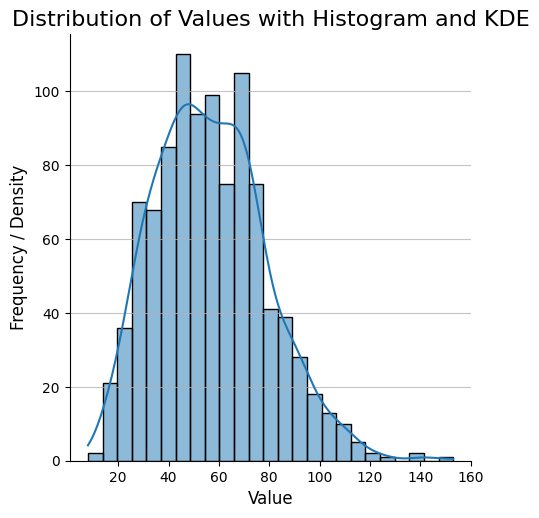

In [7]:
## 3.1 Delivery_Time_min (Target Variable)
sns.displot(data=df,x='Delivery_Time_min',kde=True, edgecolor='black')
plt.title('Distribution of Values ​​with Histogram and KDE', fontsize=16)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Frequency / Density', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

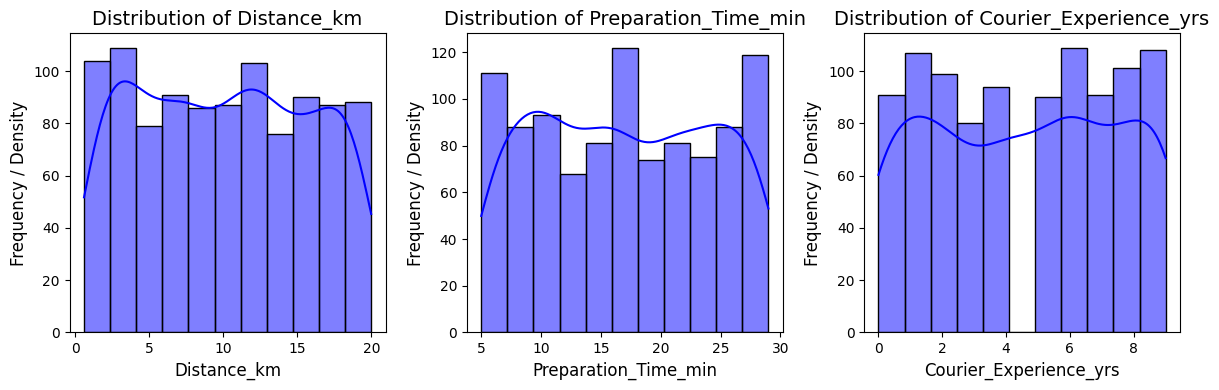

In [8]:
## Numeric Variables
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
axes = axes.flatten()

for i, col in enumerate(num_col):
    ax = axes[i]
    sns.histplot(data=df, x=col, kde=True, color='blue', edgecolor='black', ax=ax)
    ax.set_title(f'Distribution of {col}', fontsize=14)
    ax.set_xlabel(col, fontsize=12) 
    ax.set_ylabel('Frequency / Density', fontsize=12) 

plt.tight_layout()
plt.show()

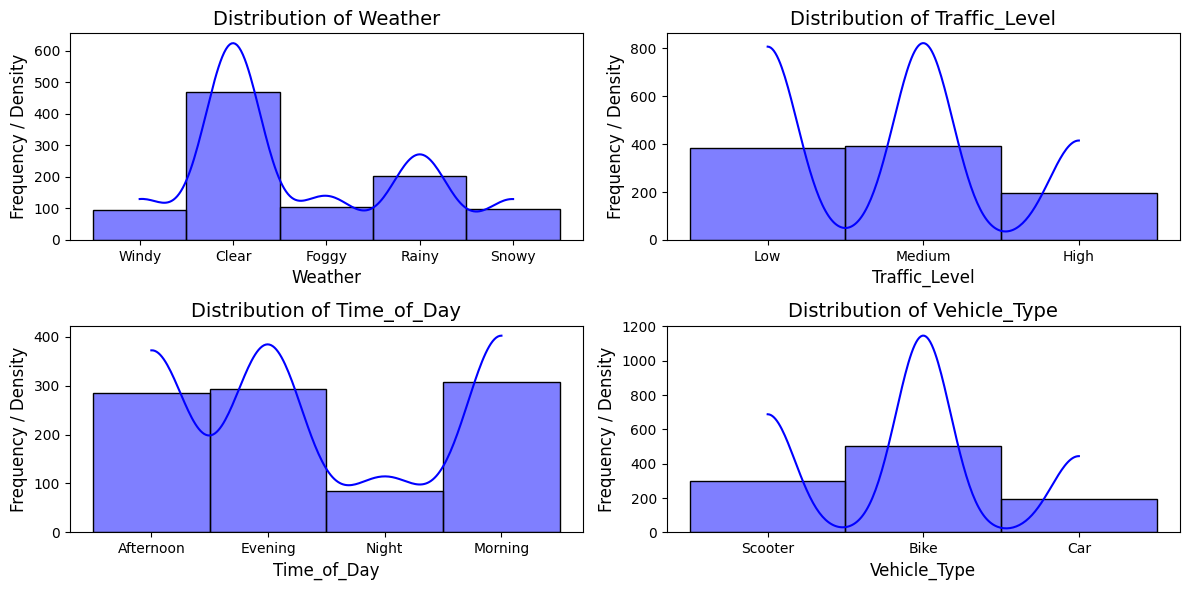

In [9]:
## Categorical Variables
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
axes = axes.flatten()

for i, col in enumerate(cat_col):
    ax = axes[i]
    sns.histplot(data=df, x=col, kde=True, color='blue', edgecolor='black', ax=ax)
    ax.set_title(f'Distribution of {col}', fontsize=14)
    ax.set_xlabel(col, fontsize=12) 
    ax.set_ylabel('Frequency / Density', fontsize=12) 

plt.tight_layout()
plt.show()

### Correlations and Dependencies

In [10]:
## Numeric
correlation_target = df[num_col].corrwith(df[target_variable])
print(correlation_target)

Distance_km               0.780998
Preparation_Time_min      0.307350
Courier_Experience_yrs   -0.090433
dtype: float64


C:\Users\wrfig\AppData\Local\Temp\ipykernel_4280\1980337279.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()


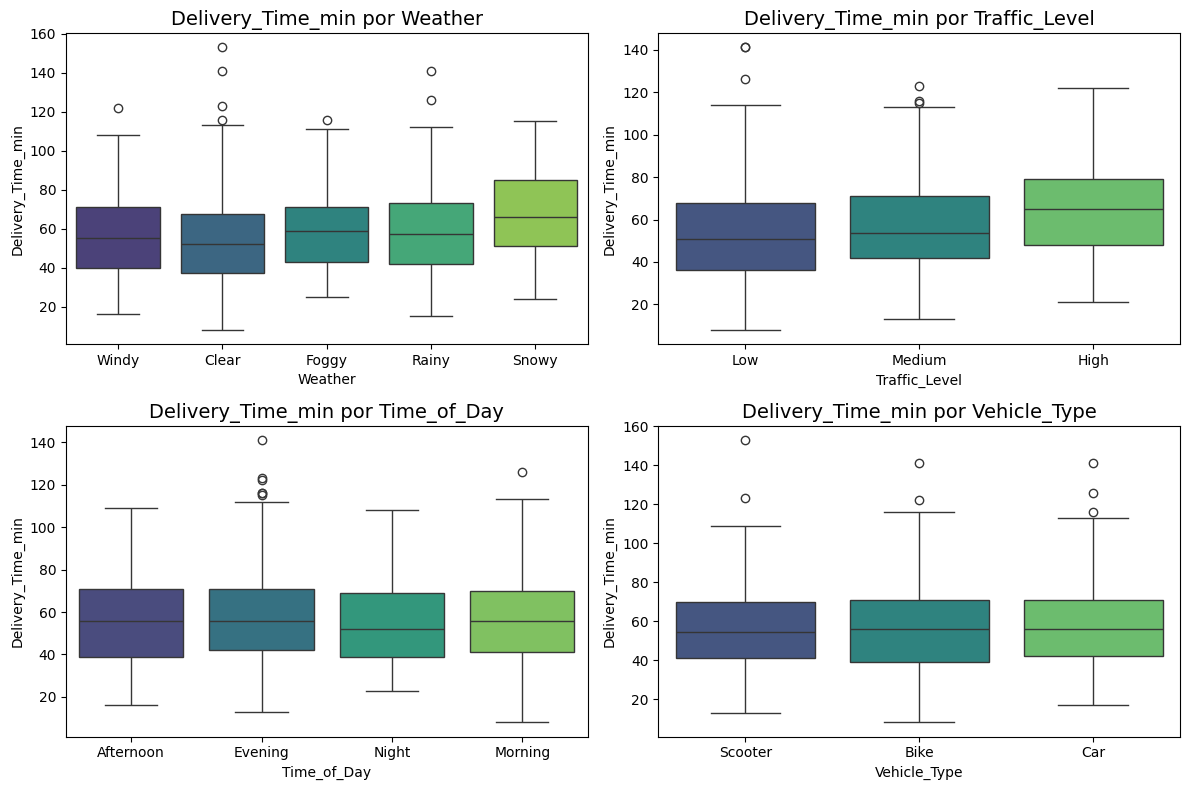

In [11]:
## Categorical
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten() 

for i, feature in enumerate(cat_col):
    ax = axes[i]
    sns.boxplot(data=df, x=feature, y=target_variable, ax=ax, palette='viridis', hue=feature)
    ax.set_title(f'{target_variable} por {feature}', fontsize=14)
    ax.set_xlabel(feature)
    ax.set_ylabel(target_variable)
    ax.legend().remove()
plt.tight_layout()
plt.show()

In [18]:
from scipy.stats import f_oneway

def anova_test(df, categorical_col, target_col):
    groups = [group[target_col].values for name, group in df.groupby(categorical_col)]
    stat, p = f_oneway(*groups)
    return p

for cat in cat_col:
    p_val = anova_test(df, cat, target_variable)
    print(f"Variable: {cat} -> p-valor: {p_val:.4f} {'(Significant)' if p_val < 0.05 else ''}")


Variable: Weather -> p-valor: 0.0000 (Significant)
Variable: Traffic_Level -> p-valor: 0.0000 (Significant)
Variable: Time_of_Day -> p-valor: 0.7765 
Variable: Vehicle_Type -> p-valor: 0.5549 


In [17]:
def correlation_ratio(categories, measurements):
    categories = np.array(categories)
    measurements = np.array(measurements)

    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat) + 1

    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)

    for i in range(cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.mean(cat_measures)

    y_total_avg = np.sum(y_avg_array * n_array) / np.sum(n_array)

    numerator = np.sum(n_array * (y_avg_array - y_total_avg)**2)
    denominator = np.sum((measurements - y_total_avg)**2)

    eta_squared = numerator / denominator if denominator != 0 else 0
    return eta_squared

for cat in cat_col:
    eta = correlation_ratio(df[cat], df[target_variable])
    print(f'Variable: {cat} -> η²: {eta:.4f}')


Variable: Weather -> η²: 0.0402
Variable: Traffic_Level -> η²: 0.0384
Variable: Time_of_Day -> η²: 0.0011
Variable: Vehicle_Type -> η²: 0.0012
